In [2]:
import e2edro.DataLoad as dl
import e2edro.BaseModels as bm
import e2edro.e2edro as ilo
import e2edro.PortfolioClasses as bt
import e2edro.PlotFunctions as pf
import torch 
from torch.utils.data import DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings
mpl.rcParams["text.usetex"] = False
warnings.simplefilter(action='ignore', category=FutureWarning)

## 1. Test Whether the Machine is well Set Up to Run the Code

In [10]:
print("CUDA available:", torch.cuda.is_available()) 
print("CUDA version:", torch.version.cuda)  
print("CUDA version:", torch.version.cuda)
print("Torch version:", torch.__version__)
print("GPU:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")

CUDA available: True
CUDA version: 12.6
CUDA version: 12.6
Torch version: 2.6.0+cu126
GPU: NVIDIA GeForce RTX 4070 Laptop GPU


## 2. Load the Data, Read Dataset Dimensions, and Set the Testing Window

In [4]:
start = "2000-07-01"
end = "2021-10-01"   
# start = "2013-01-01"
# end = "2025-04-30"
split = [0.6, 0.4,0.0]
seed = 42 

# Import the data. The DataLoad AV() function now fetches data from yahoo finance
features_object, rets_object = dl.AV(start=start, end=end, split=split)

# Compute data parameters
n_x = features_object.train().shape[1]
n_y = rets_object.train().shape[1]
n_obs = features_object.n_obs

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  20 of 20 completed


In [5]:
print("Training Set Features dims: ", features_object.train().shape)
print("Training Set Returns dims: ", rets_object.train().shape)
print("Number of observations in a prediction window:: ", n_obs)

Training Set Features dims:  (665, 8)
Training Set Returns dims:  (665, 20)
Number of observations in a prediction window::  104


## 3. Compute and Backtest the Basic Models

### 3.1. Compute and Test the Equally Weighted Portfolio Problem 

In [6]:
# Instantiate the EW model
ew = bm.equal_weight(n_x=n_x, n_y=n_y, n_obs=n_obs)

# Run the back test of the model
ew.net_roll_test(features_object, rets_object, n_roll=4)

### 3.2. Compute and Test the Naive Predict-then-Optimize Model

In [7]:
# how come sometimes on a first run it yields an error?!
# Instantiate the nominally-DR PO model
po = bm.pred_then_opt(n_x=n_x, 
                      n_y=n_y, 
                      n_obs=n_obs,                       
                      prisk='p_var', 
                      opt_layer='nominal',
                      set_seed=seed)

po.double() # A conflict of dtypes otherwise, float vs double

# Run the back test of the model
po.net_roll_test(features_object, rets_object, n_roll=4)

Out-of-sample window: 1 / 4
Out-of-sample window: 2 / 4
Out-of-sample window: 3 / 4
Out-of-sample window: 4 / 4


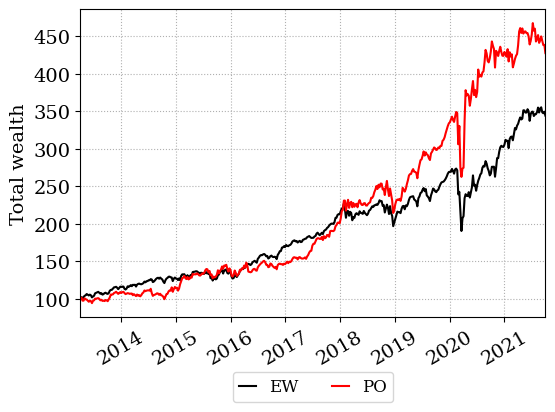

In [8]:
# Plot the backtest result
pf.wealth_plot([ew.portfolio, po.portfolio], 
                ['EW', 'PO'], 
               ['black', 'red']
              ) 

## 4. Compute and Backtest each Investment System on the Uploaded Data

### 4.1. Illustrate the Training and Inference Flow for the End-to-End Systems

In [9]:
# Prepare the data for training and for inference of the mean returns over perf_period (not the real returns)
train_set = DataLoader(
              bt.SlidingWindow(
                        features_object.train(), 
                        rets_object.train(), 
                        n_obs=n_obs,
                        perf_period=13
                    )
                )

# Extract test features (X) and realizations (Y)
X_test = features_object.test()
Y_test = rets_object.test()

# Set the device to CUDA if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Convert test sets to PyTorch tensors and move them to the device. Ensure tensors are properly shaped
X_tensor = torch.tensor(X_test.values, dtype=torch.double).to(device).squeeze() 
Y_tensor = torch.tensor(Y_test.values, dtype=torch.double).to(device).squeeze() 

print("Testing Set Features dims: ", X_tensor.shape)
print("Testing Set Returns dims: ", Y_tensor.shape)

Using device: cuda


RuntimeError: CUDA error: CUDA-capable device(s) is/are busy or unavailable
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [12]:
# Instantiate the model
e2e_base = ilo.e2e_net(n_x=n_x, 
                      n_y=n_y, 
                      n_obs=n_obs, 
                      opt_layer='base_mod', 
                      pred_model='2layer', 
                      set_seed=seed)

e2e_base.double() # A conflict of dtypes otherwise, float vs double

e2e_base.net_train(
    train_set = train_set,
    val_set   = None,
    epochs    = 15,
    lr        = 1e-3,
)

# Set the model to evaluation mode (for inference)
e2e_base.eval()  

# Pass the test data through the forward method
with torch.no_grad():  # Disable gradient computation for inference
    z_star, y_hat = e2e_base(X_tensor, Y_tensor)

# Output the predictions and optimal weights
print("Sample Optimal Weights (z_star):", z_star)
print("Sample Mean Returns Predictions (y_hat):", y_hat)

Sample Optimal Weights (z_star): tensor([[8.7441e-11],
        [5.5142e-11],
        [3.7683e-11],
        [6.1966e-11],
        [3.9335e-11],
        [7.3455e-11],
        [3.5176e-11],
        [1.0000e+00],
        [3.3645e-11],
        [7.1431e-11],
        [7.6805e-11],
        [6.8575e-11],
        [7.0463e-11],
        [4.1241e-11],
        [5.4429e-11],
        [3.5237e-11],
        [6.0357e-11],
        [5.1671e-11],
        [6.4158e-11],
        [7.5885e-11]], device='cuda:0', dtype=torch.float64)
Sample Mean Returns Predictions (y_hat): tensor([ 0.1015, -0.0789,  0.0963,  0.0594, -0.1695, -0.0045, -0.2051,  0.1255,
        -0.2203, -0.0134,  0.0172, -0.0248,  0.0488, -0.1555, -0.0821, -0.2045,
        -0.0569, -0.0950,  0.0572,  0.0087], device='cuda:0',
       dtype=torch.float64)


### 4.2. Instantiate all end-to-end systems

In [7]:
e2e_base = ilo.e2e_net(n_x=n_x, 
                      n_y=n_y, 
                      n_obs=n_obs, 
                      opt_layer='base_mod', 
                      pred_model='linear', 
                      set_seed=seed)

e2e_base2 = ilo.e2e_net(n_x=n_x, 
                      n_y=n_y, 
                      n_obs=n_obs, 
                      opt_layer='base_mod', 
                      pred_model='2layer', 
                      set_seed=seed)
 
e2e_baseMV = ilo.e2e_net(n_x=n_x, 
                        n_y=n_y, 
                        n_obs=n_obs, 
                        sigma=rets_object.train().cov(),  # A fix needs to be found for estimating the cov matrix with each roll.
                        opt_layer='baseMV', 
                        pred_model='linear', 
                        train_kappa=True,
                        set_seed=seed)

e2e_dr = ilo.e2e_net(n_x=n_x, 
                    n_y=n_y, 
                    n_obs=n_obs, 
                    pred_model='linear', 
                    opt_layer='hellinger', 
                    train_gamma=True,
                    train_delta=True,
                    set_seed=seed)

e2e_base.double()
e2e_baseMV.double()
e2e_dr.double()

e2e_net(
  (pred_loss): MSELoss()
  (pred_layer): Linear(in_features=8, out_features=20, bias=True)
  (opt_layer): CvxpyLayer()
)

In [23]:
e2e_baseMV_untrain_kappa = ilo.e2e_net(n_x=n_x, 
                        n_y=n_y, 
                        n_obs=n_obs, 
                        sigma=rets_object.train().cov(),  # A fix needs to be found for estimating the cov matrix with each roll.
                        opt_layer='baseMV', 
                        pred_model='linear', 
                        train_kappa=False,
                        set_seed=seed)

### 4.3. Run Backtests for all systems

In [10]:
# Prepare data for testing
train_set = DataLoader(
              bt.SlidingWindow(
                        features_object.train(), 
                        rets_object.train(), 
                        e2e_base.n_obs,
                        e2e_base.perf_period
                    )
                )

# Run the backtests
folios =['ew', 'po', 'e2e_base', 'e2e_base2', 'e2e_baseMV']

for p in folios:
    eval(p).net_roll_test(features_object, rets_object, n_roll=4)

Out-of-sample window: 1 / 4
Out-of-sample window: 2 / 4
Out-of-sample window: 3 / 4
Out-of-sample window: 4 / 4
Out-of-sample window: 1 / 4
Out-of-sample window: 2 / 4
Out-of-sample window: 3 / 4
Out-of-sample window: 4 / 4
Out-of-sample window: 1 / 4
Out-of-sample window: 2 / 4
Out-of-sample window: 3 / 4
Out-of-sample window: 4 / 4


### 4.4. Display the Performace Results 

In [12]:
folios =['ew', 'po', 'e2e_base', 'e2e_base2', 'e2e_baseMV']
folio_labels = ['EW', 'PO', 'E2E-Linear Base', 'E2E-NN Base', 'E2E-Linear Base MV']

# Display system evaluations
_dict = {p: [eval(p+'.portfolio').mean, 
             eval(p+'.portfolio').vol,
             eval(p+'.portfolio').sharpe,
             eval(p+'.portfolio').weights]
         for p in folios
        }

results = (pd.DataFrame(_dict, index=['Mean', 'Volatility', 'Sharpe Ratio', 'Weights'])
            .rename(columns = {folios[i] : folio_labels[i] for i in range(len(folios))})
             .transpose()
)

results

,Mean,Volatility,Sharpe Ratio,Weights
EW,0.002795,0.020871,0.133936,"[[0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0...."
PO,0.003287,0.026296,0.124994,"[[6.891625362676277e-09, 0.17843372650559214, ..."
E2E-NN Base,0.001121,0.026047,0.043037,"[[1.237640526948861e-10, 5.16947176777257e-11,..."
E2E-Linear Base MV,0.005524,0.033918,0.162856,"[[0.7000626980907321, 2.0162993440736107e-09, ..."


### 4.5. Plot the Wealth Growth

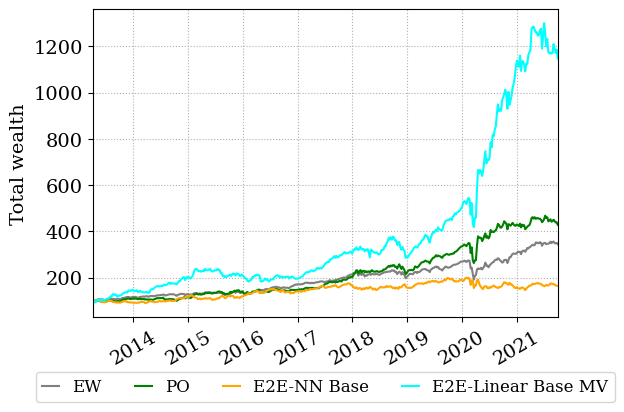

In [13]:
folios =['ew', 'po', 'e2e_base', 'e2e_base2', 'e2e_baseMV']
folio_labels = ['EW', 'PO', 'E2E-Linear Base', 'E2E-NN Base', 'E2E-Linear Base MV']
colors = ['grey', 'green', 'orange', 'purple', 'cyan']

# Plot the wealth based on backtests
pf.wealth_plot([eval(p).portfolio for p in folios], 
               folio_labels,
                 colors) 

## 5. Experiments

### 5.1. Isolate the effect of the risk aversion parameter $\kappa$

In [17]:
e2e_baseMV_untrained = ilo.e2e_net(n_x=n_x, 
                        n_y=n_y, 
                        n_obs=n_obs, 
                        sigma=rets_object.train().cov(), 
                        opt_layer='baseMV', 
                        pred_model='linear', 
                        train_kappa=False,
                        set_seed=seed)

In [18]:
e2e_baseMV_untrained.double()
e2e_baseMV_untrained.net_roll_test(features_object, 
                                   rets_object, 
                                   n_roll=4)

Out-of-sample window: 1 / 4
Out-of-sample window: 2 / 4
Out-of-sample window: 3 / 4
Out-of-sample window: 4 / 4


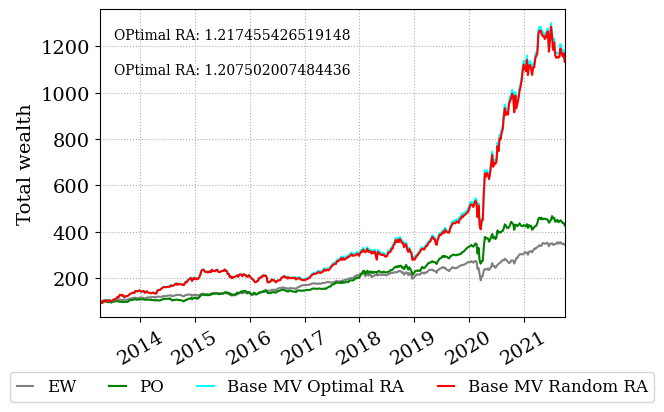

In [20]:
folios =['ew', 'po', 'e2e_baseMV', 'e2e_baseMV_untrained']
folio_labels = ['EW', 'PO', 'Base MV Optimal RA', 'Base MV Random RA']
colors = ['grey', 'green', 'cyan', 'red']
# Plot the wealth based on backtests
pf.wealth_plot([eval(p).portfolio for p in folios], 
               folio_labels,
               colors) 
plt.annotate(f"OPtimal RA: {e2e_baseMV.kappa
                            .detach().cpu().item()}",
              xy=(10,200), xycoords='axes points')

plt.annotate(f"OPtimal RA: {e2e_baseMV_untrained.kappa
                            .detach().cpu().item()}",
              xy=(10,175), xycoords='axes points')

plt.show()

### Compute the Allocation Metrics for each Model

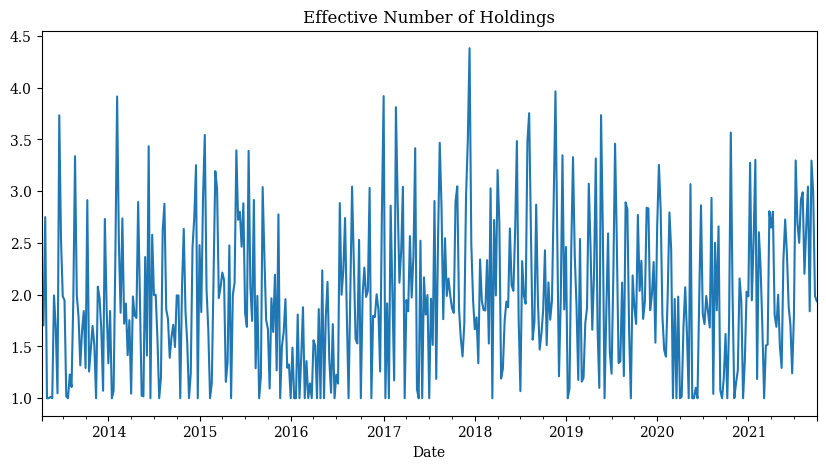

In [75]:
hhi = np.sum( results.Weights.loc['E2ELinear Base MV']**2, 
              axis =1)

plt.figure(figsize=(10,5))
(pd.Series(1/hhi, 
           index = e2e_baseMV.portfolio.dates)
        ).plot()

plt.title('Effective Number of Holdings')
plt.show()

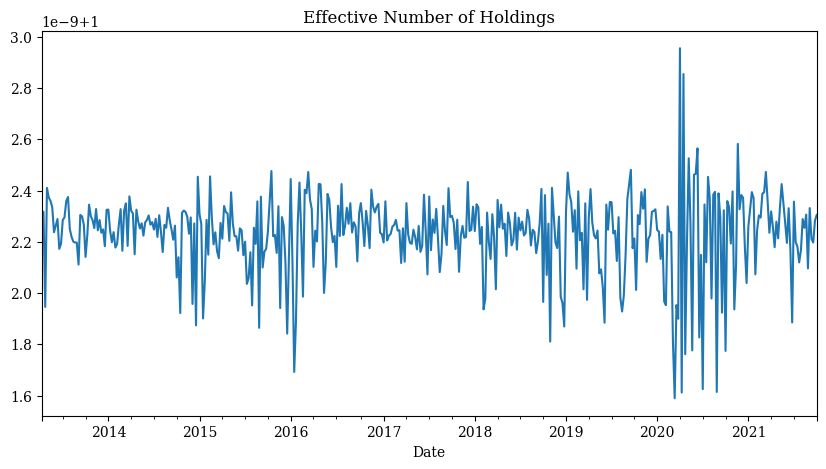

In [22]:
hhi = np.sum( results.Weights.loc['E2E-NN Base']**2, 
              axis =1)

plt.figure(figsize=(10,5))
(pd.Series(1/hhi, 
           index = e2e_base.portfolio.dates)
        ).plot()

plt.title('Effective Number of Holdings')
plt.show()

## Compute and Test the End-to-End DR Model

In [113]:
# Instantiate the model
e2e_dr = ilo.e2e_net(n_x=n_x, 
                    n_y=n_y, 
                    n_obs=n_obs, 
                    pred_model='linear', 
                    opt_layer='hellinger', 
                    train_gamma=True,
                    train_delta=True,
                    set_seed=seed)

e2e_dr.double() # A conflict of dtypes otherwise, float vs double

# Train the model
train_set = DataLoader(
                    bt.SlidingWindow(
                        features_object.train(), 
                        rets_object.train(), 
                        e2e_dr.n_obs, 
                        e2e_dr.perf_period
                    )
                )

e2e_dr.net_train(
    train_set = train_set,
    val_set   = None,
    epochs    = 5,
    lr        = 1e-3,
)

# Run the back test of the model
e2e_dr.net_roll_test(features_object, rets_object, n_roll=4)


Out-of-sample window: 1 / 4


/home/ramiuness/anaconda3/envs/e2e-space/lib/python3.12/site-packages/diffcp/cone_program.py:422: UserWarning: Solved/Inaccurate.
  warnings.warn("Solved/Inaccurate.")


Out-of-sample window: 2 / 4


/home/ramiuness/anaconda3/envs/e2e-space/lib/python3.12/site-packages/diffcp/cone_program.py:422: UserWarning: Solved/Inaccurate.
  warnings.warn("Solved/Inaccurate.")


Out-of-sample window: 3 / 4


/home/ramiuness/anaconda3/envs/e2e-space/lib/python3.12/site-packages/diffcp/cone_program.py:422: UserWarning: Solved/Inaccurate.
  warnings.warn("Solved/Inaccurate.")


Out-of-sample window: 4 / 4


/home/ramiuness/anaconda3/envs/e2e-space/lib/python3.12/site-packages/diffcp/cone_program.py:422: UserWarning: Solved/Inaccurate.
  warnings.warn("Solved/Inaccurate.")


### Collect and Plot the Test Results

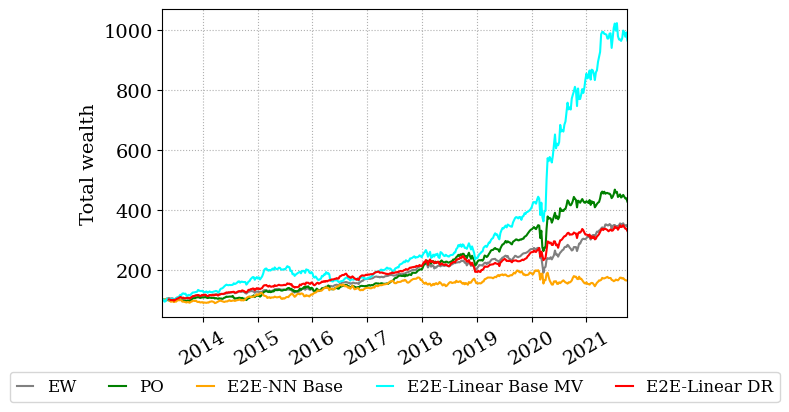

In [114]:
folios =['ew', 'po', 'e2e_base', 'e2e_baseMV', 'e2e_dr']
folio_labels = ['EW', 'PO', 'E2E-NN Base', 'E2E-Linear Base MV', 'E2E-Linear DR']
colors = ['grey', 'green', 'orange', 'cyan', 'red']

# Plot the wealth based on backtests
pf.wealth_plot([eval(p).portfolio for p in folios], 
               folio_labels,
                 colors) 